# 15 Synthetic Control

- DID에서 봤던 상황을 그대로 생각해보자.
- 하지만 다른 점은 aggregated data만 있는 것이다.

$$(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) \\= (87.06 - 206.16) - (46.01 - 171.64) = 6.53$$

|도시|before|after|
|------|---|---|
|FL|171.64|206.16|
|POA|46.01|87.06|

- 이런 경우 DID estimator는 구할 수 있지만 SE는 구할 수 없다.
- 또한, FL이 정말 POA의 적절한 control group인지 헷갈린다.
- 이럴때 사용할 수 있는게 Synthetic Control 방법이다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

# pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

- estimaing the effect of cigarette taxation on its consumption
  - 담배의 가격을 올리면 수요가 줄 것이다 vs 담배는 중독이라 바뀌지 않는다.
- California에서 `Proposition 99`이라는 정책으로 1988년에 담배의 가격을 올렸었다. 
  - 이와 관련하여 1970년부터 2000년까지 39개의 (control) states의 데이터를 수집했다.
  - California와 비슷한 정책이 있었던 state는 제외했다.

In [2]:
cigar = (pd.read_csv("data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


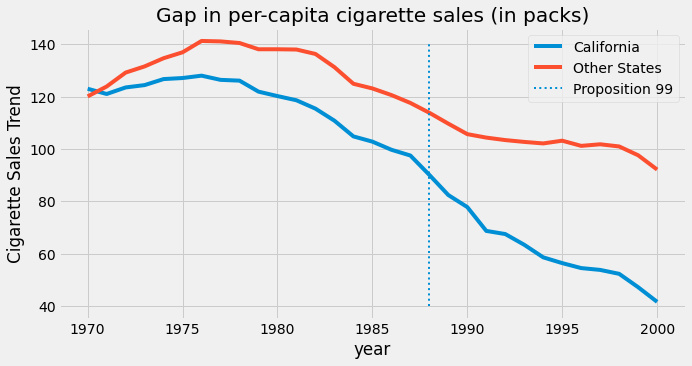

In [3]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

- 그림으로 봐서는 정책이 효과가 있을 것 같다. 하지만 이는 확실하지 않으니 확인해보자.
- 확인하는 방법은
  - 다른 states을 잘 섞어서 build a fake state that resembles very closely the trend of California!

## We have Time

- $J+1$개의 unit이 있다고 하자.
  - 1개는 intervention을 받은 unit
  - 나머지 $J$개는 untreated unit들이다.
- 각 unit $j$, time $t$ 마다 outcome $Y_{jt}$가 있다.
  - $Y^N_{jt}$: potential outcome without intervention
  - $Y^I_{jt}$: potential outomce with intervention
- $T_0$는 intervention 이전의 time을 의미한다.

- 따라서 the effect for the treated unit $j=1$ at time $t$, for $t > T_0$ is defined as

$$\tau_{1t} = Y^I_{jt} - Y^N_{jt}$$

- $j=1$의 경우 treated one이기 때문에 우리가 알 수 없는 것은 $Y^N_{jt}$ 이부분이다.
- 그래서 이를 approximate하기 위해 untreated unit들의 weighted sum을 이용한다: synthetic control estimate of $Y^N_{jt}$

$$\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}$$

## Synthetic Control as Linear Regression

- synthetic control을 통해서 treatment effect를 estimate하기 위해서는 intervention 이전의 treated unit과 비슷한 fake unit을 만들어야 한다.
- 이를 위해 linear regression을 이용해보자.
- 일단 이를 위해 데이터 세팅부터 한다.
  - 일단 column은 각 unit들이 되고 row는 time별 outcome값이 된다.
  - feature가 여러개인 경우 concat한다. (row에 추가)

In [4]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

In [5]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [6]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

- weight를 구했다.
- 이를 이용해서 fake counterfactual을 만들자.

In [7]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

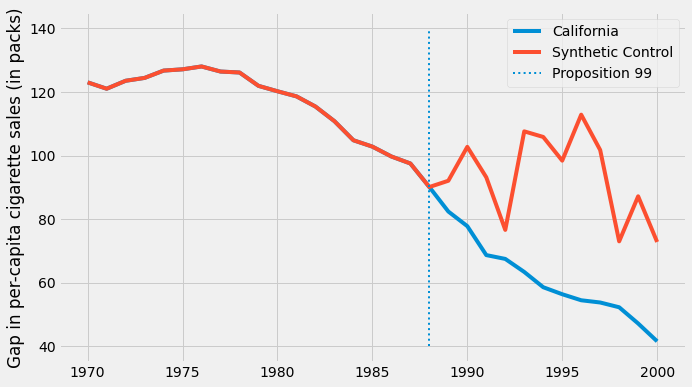

In [8]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

- 좀 그림이 이상하긴하다.
  - outcome의 variance가 너무 큰거 아닌가?
- 일단 California에서의 intervention이 효과적이라는 생각이 든다.
- 그리고 intervention이전의 outcome은 상당히 잘 맞춘다.
  - overfit이라고 할 수 있을까?
- 여기서의 문제는 아마 row에 비해 column이 많아서 발생한게 아닐까? lasso나 ridge를 사용한다면?

## Don't Extrapolate

- unit들의 weight sum은 extrapolate하는 것이라서 이상한 값을 가질 확률이 생긴다.
  - 원래 양수만 가져야하는데 음수가 나오는 것이 그 예시라고 할 수 있다.
- 그렇다면 synthetic control을 interpolation으로 제한할 수 있지 않을까?
- weight를 positive하고 sum up to one이라는 제약을 주자.
- 하지만 이또한 단점이 있다.
  - 제약이 생긴만큼 perfect match를 못 만들 수도 있다.
  - 많은 unit들에게 weight를 0으로 부여할 수 있다.

- 실제 데이터를 이용하여 weight를 구해보자.
- `scipy`을 이용해서 quadratic programming한다.

In [9]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

from scipy.optimize import fmin_slsqp

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                            np.array(w_start),
                            f_eqcons=lambda x: np.sum(x) - 1,
                            bounds=[(0.0, 1.0)]*len(w_start),
                            disp=False)
    return weights

In [10]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [11]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

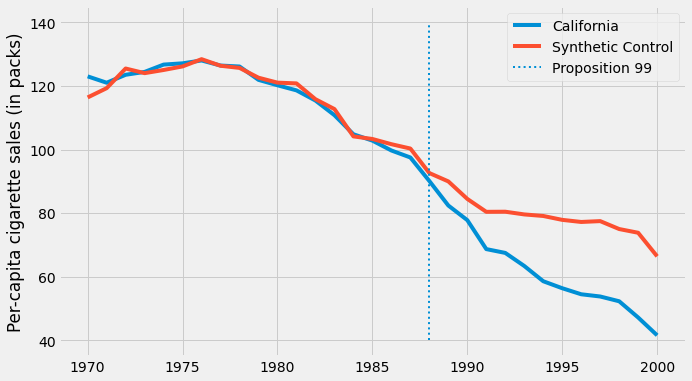

In [12]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

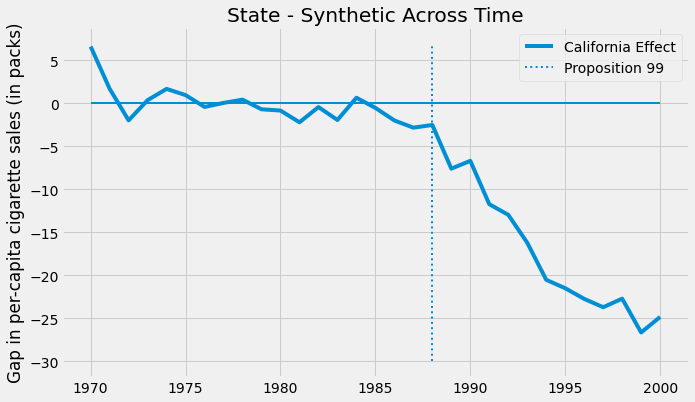

In [13]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

## Making Inference

- 그런데 데이터의 크기가 39개 밖에 안되니까 위의 결과가 통계적으로 유의미한지 모르겠다. 
  - 정책이 효과가 있는지
- 그렇다면 이를 확인하기 위해 각 untreated unit을 하나씩 treated unit이라고 가정하고 synthetic control을 진행해보자.

In [14]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

In [15]:
synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


In [16]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [17]:
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


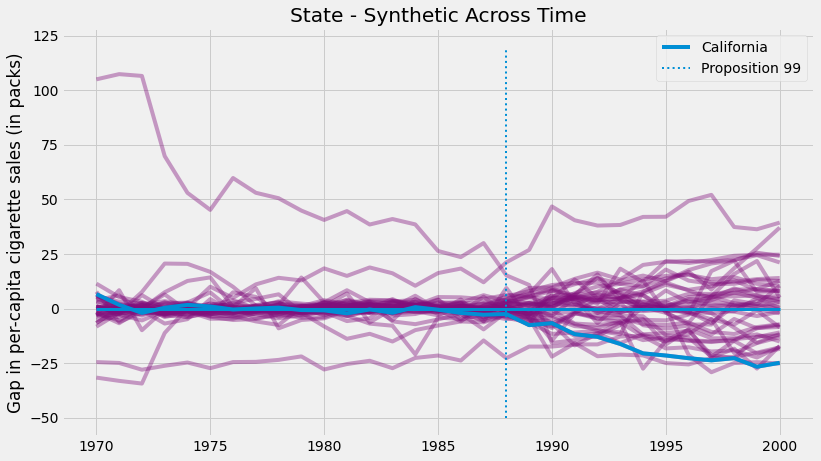

In [18]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

- 위의 그림을 보면 intervention이전의 기간을 잘 맞추지 못하는 경우가 종종있다.
- 이들을 threhold로 없애자.

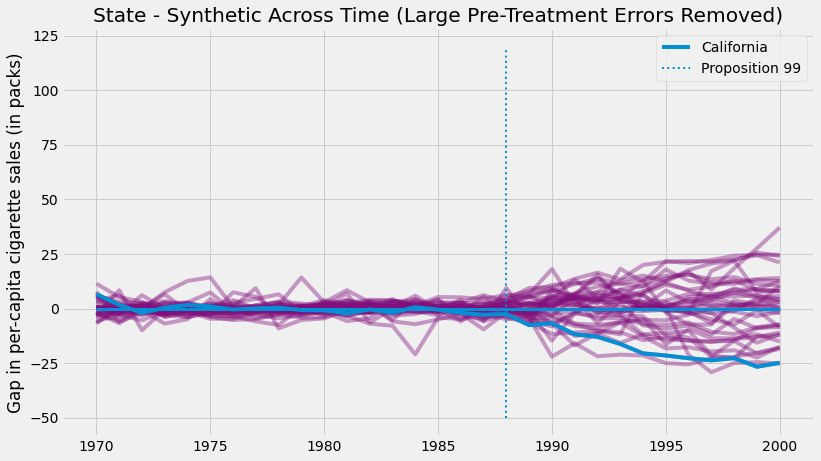

In [19]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

- 그림으로 봤을 때, 일단 정책이 효과가 있을 것 같다는 생각이 든다.
- 그렇다면 이제 p-value를 구해보자.

In [20]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.83015975607075


array([  5.79715888,   0.89458999, -24.83015976,  -7.16628124,
       -10.92204862,  37.1164056 , -15.0697171 ,  -0.49805136,
       -18.4579509 ,  21.13366447,  12.57782738,  -1.47547826,
        10.49627373, -11.67012367,   4.2985083 ,   8.04811402,
        14.02322406,   8.25002715,   0.32576355,  -8.40826877,
        -2.12402707,  -7.42865061,   2.96157562,  24.10478092,
         4.25211766, -17.75844576,   7.93334017,   2.81640133,
        12.6495598 , -17.47677515, -25.1604094 , -12.26469132,
        24.69067376,  10.36299574,  -8.59880332])

- one sided hypothesis
  - California의 effect가 다른 effect들 보다 몇 번이나 크게 나왔는지

$$PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\}$$

In [21]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857